# CNC SMS Future Prediction LSTM

Иммется временной ряд отправленных СМС оповещений за 4 месяца с периодичнотью в 10 мин.
Требуебся выдать прогноз на n временных интервалов вперед и визуализировать результаты используя рекуррентные нейроннный сети с долгосрочно-краткосрочной памятью

In [2]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler 

from keras.models import Sequential  
from keras.layers import Dense, LSTM, Dropout 
from keras.layers.advanced_activations import *

pd.options.display.float_format = '{:.3f}'.format

WINDOW = 6*24*3
HORIZON = 6*12

Populating the interactive namespace from numpy and matplotlib


Загрузим входные данные, сделаем их предобработку, выведем некоторые статистические показатели, и визуализируем их

count    24768.000
mean     68637.886
std      42793.965
min          1.000
25%      30642.750
50%      68145.500
75%      96240.000
max     886752.000
Name: Value, dtype: float64


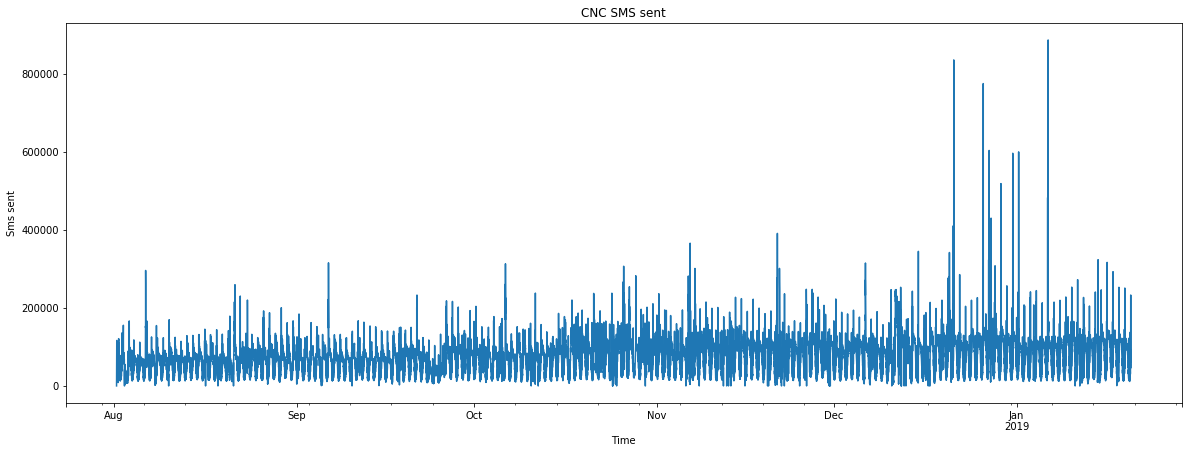

In [3]:
df = pd.read_csv('10min.csv', sep=';', index_col=['Time'], parse_dates=['Time'], dayfirst=True)
df = df.drop(df['Value'].tail(1).index)
n = int(df['Value'].size/2)
df = df[n:]
df['Value'] = df['Value'].apply(lambda text: ''.join(j for j in text if ord(j) < 128))
df['Value'] = df['Value'].apply(lambda val: float(val))
df['Value'] = df['Value'].apply(lambda val: 1 if val <= 0 else val)
df['Value'] = df['Value'].asfreq('10min', method='pad')
data = df['Value']
plt.figure(figsize(20,7))
data.plot()
plt.title("CNC SMS sent")
plt.ylabel('Sms sent')

print(data.describe())

Нормализуем входные данные по формуле: 
    $${X_i}_{normalized}=\frac{X_i−X_{min}}{X_{max}−X_{min}} $$

И разделим наши данные на множества X (признаков) и Y (меток)  
Для подготовки данных будем пользоваться принципом скользящего окна.  
Таким образом, на вход сети подается массив длиной n из окон заданного размера m из значений за m промежутков времени, а на выходе мы хотим знать значение в m+1 промежуток времени  
Для работы LSTM слои нам нужно преобразовать входные данные - признаки в 3D тензоры. Просто добавим одно измерение функцией из numpy

In [4]:
data = np.expand_dims(data, axis=1)

scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(data)

In [5]:
features = []  
labels = []

for i in range(WINDOW, data.size-HORIZON):  
    features.append(data_scaled[i-WINDOW:i])
    labels.append(data_scaled[i:i+HORIZON])


features, labels = np.array(features), np.array(labels) 
features = np.reshape(features, (features.shape[0], features.shape[1], 1)) 

In [6]:
#Срежем одно измерение если пронозируем больше чем на 1 шаг вперед
labels = np.squeeze(labels,axis=2)

Разделим множества признаокво и и меток на обучающую и тестовую выборки в соотношении 8/2

In [7]:
validation_barrier = int(len(labels)*0.8)

Y_train = labels[:validation_barrier]
X_train = features[:validation_barrier]
Y_test = labels[validation_barrier:]
X_test = features[validation_barrier:]

Тут можно долго играться с функциями активации, количеством слоев/нейронов, дропаутом и рекуррентным дропаутом 

In [11]:
act_func = 'tanh'

model = Sequential()  
model.add(LSTM(units=50, activation=act_func, return_sequences=True, input_shape=(features.shape[1], 1)))  
model.add(Dropout(0.2))  



model.add(LSTM(units=50, activation=act_func))  
model.add(Dense(units = HORIZON))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [15]:
history = model.fit(X_train, Y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_test, Y_test),
                    shuffle=False)

#predictions = scaler.inverse_transform(predictions) 

Train on 19411 samples, validate on 4853 samples
Epoch 1/10
19411/19411 [==============================] - 155s 8ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 2/10
19411/19411 [==============================] - 149s 8ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 3/10
19411/19411 [==============================] - 164s 8ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 4/10
19411/19411 [==============================] - 144s 7ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 5/10
19411/19411 [==============================] - 139s 7ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 6/10
19411/19411 [==============================] - 139s 7ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 7/10
19411/19411 [==============================] - 138s 7ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 8/10
19411/19411 [==============================] - 138s 7ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 9/10
19411/19411 [==============================] - 138s 7ms/step - loss: 0.0010 - val_loss: 0.00

Выведем статистику обучения

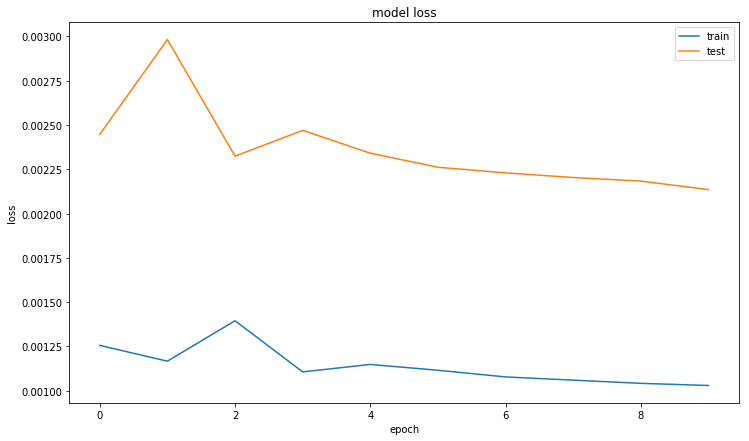

In [16]:
plt.figure(figsize=(12,7))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

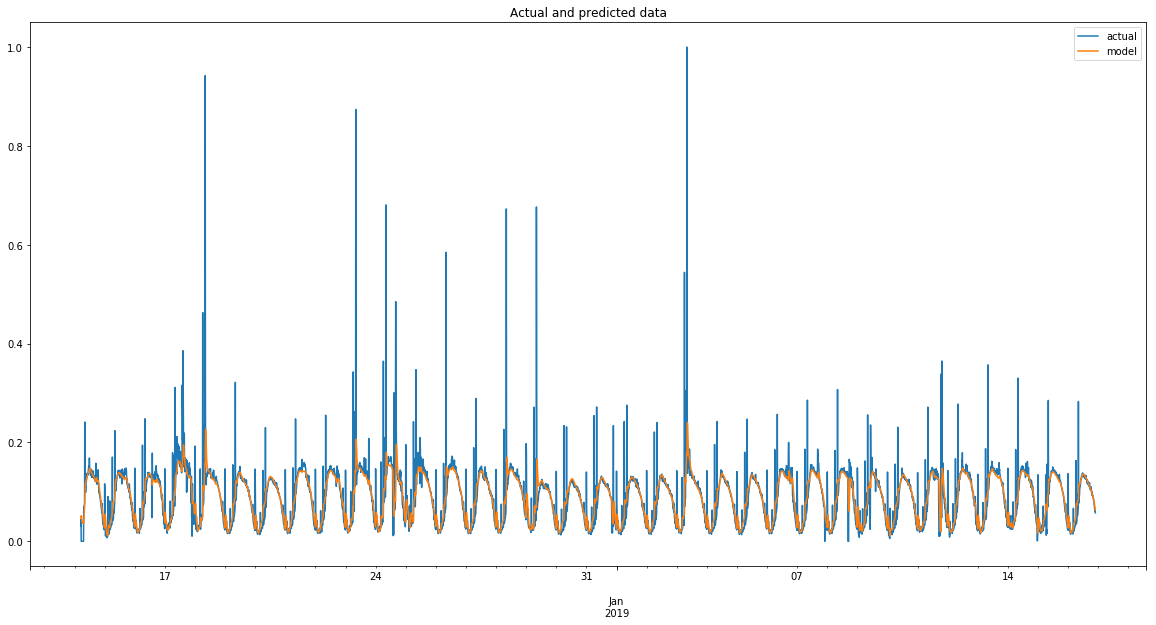

In [41]:
plt.figure(figsize(20,10))

pred = model.predict(X_test)

beg = df['Value'].index[validation_barrier]
end = df['Value'].index[-WINDOW-HORIZON-1]

dates = pd.date_range(start=beg, end=end, freq='10min')

original = []
predict = []
for i in range(len(Y_test)):
    original.append(Y_test[i][0])
    predict.append(pred[i][0])
    
  
predicted = pd.Series(predict, index=dates)
actual = pd.Series(original, index=dates)

actual.plot(label='actual')
predicted.plot(label='model')
plt.legend(loc='best')
plt.title('Actual and predicted data')
plt.show()

А теперь визуализируем меньший интревал - 1 день:

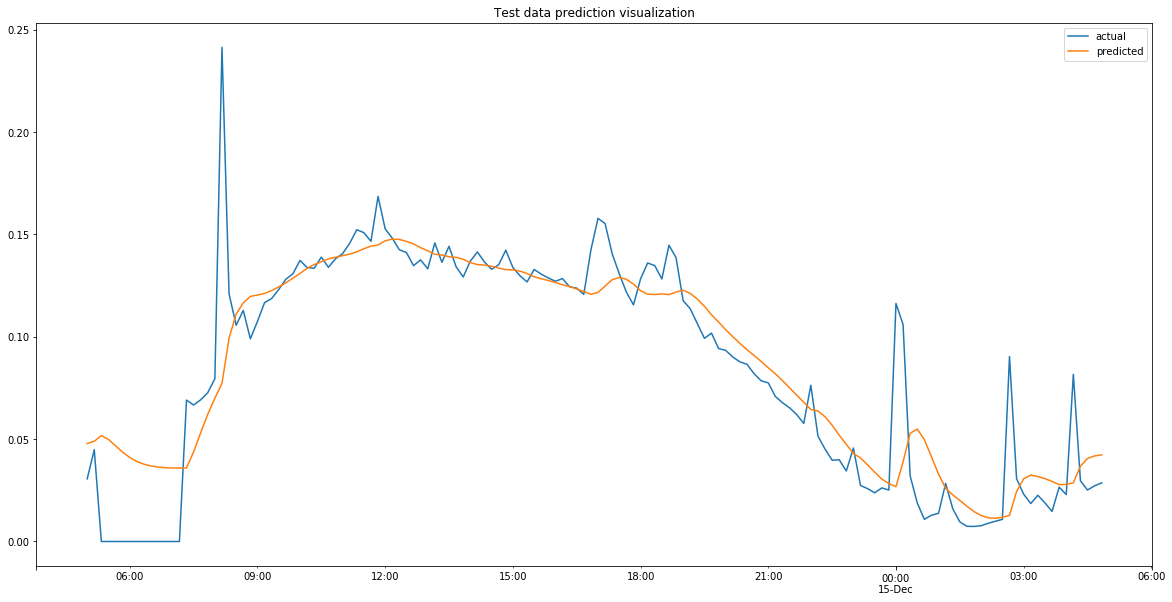

In [18]:
FROM = 0
TO = 6*24

actual[FROM:TO].plot(label='actual')
predicted[FROM:TO].plot(label='predicted')
plt.legend(loc='best')
plt.title('Test data prediction visualization')
plt.show()

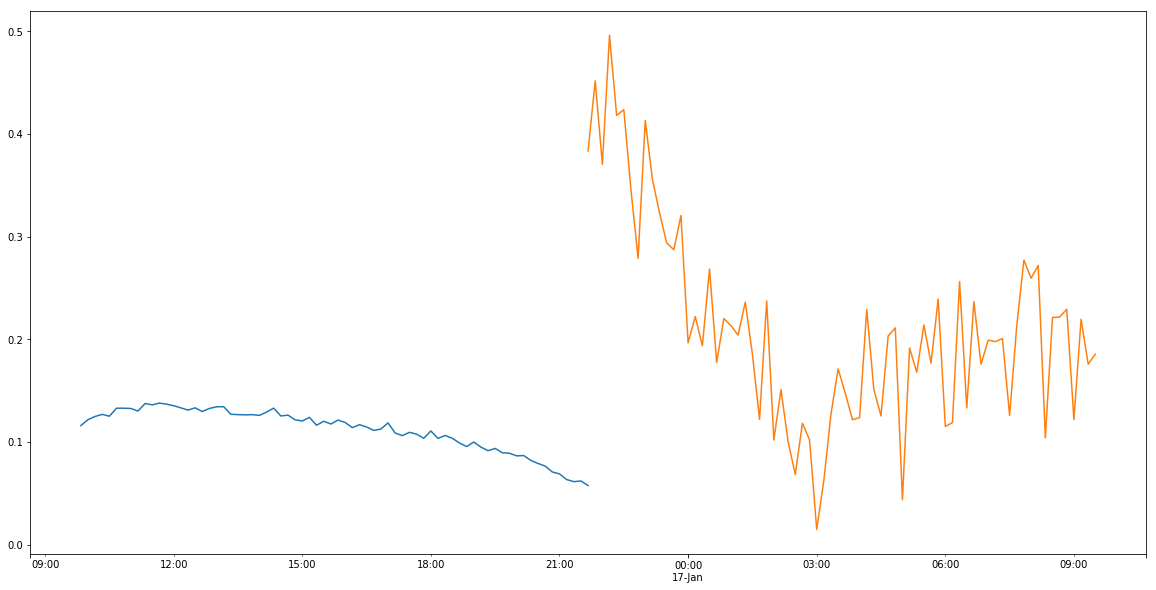

In [61]:
X_pred = []
for i in range(data.size-HORIZON, data.size):  
    X_pred.append(data[i-WINDOW:i])

X_pred = np.array(X_pred)

last_measurement = actual.index[-1]
forecast_dates = pd.date_range(start=last_measurement, periods=HORIZON, freq='10min')

forecast_data = model.predict(X_pred)
forecast = pd.Series(forecast_data[-1],index=forecast_dates)

actual[-HORIZON:].plot()
forecast.plot()
plt.show()